In [1]:
import cv2
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread
from math import sqrt, pi, log
from statistics import median, mean
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def get_params(image):

    size = image.shape[0]
    negated = cv2.bitwise_not(image)
    nlabels, _, stats, _ = \
        cv2.connectedComponentsWithStats(
            image=negated,
            labels=None,
            stats=None,
            centroids=None,
            connectivity=8,
            ltype=cv2.CV_32S
        )

    thicknesses, areas = [], []
    for i in range(1, nlabels):        
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        areas.append(area)
        bbox_diagonal = sqrt((w**2 + h**2))
        thickness = area / bbox_diagonal
        thicknesses.append(thickness)
    
    radius = size / 2
    tca = sum(areas) / (pi * radius**2)

    lengths = [area / median(thicknesses) for area in areas]

    n, total_nc = 5, 0
    for i in range(1, n + 1):
        ith_line = negated[i * size // (n + 1)]
        for j in range(len(ith_line) - 1):
            if ith_line[j] == 0 and ith_line[j + 1] == 255:
                total_nc += 1
    cd = total_nc / n

    return {
        "tca": tca,
        "lengths": lengths,
        "avg_length": mean(lengths),
        "25_length": np.percentile(lengths, 25),
        "75_length": np.percentile(lengths, 75),
        "total_cracks": len(lengths),
        "cd": cd,
    }

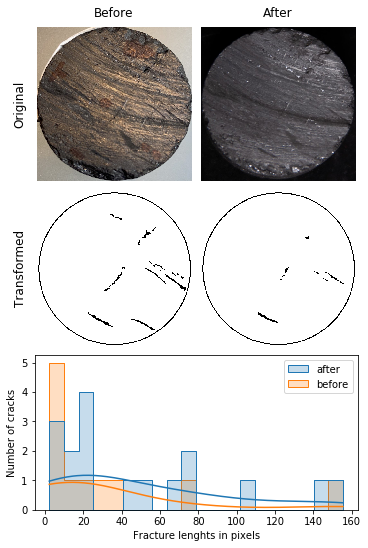

<Figure size 432x288 with 0 Axes>

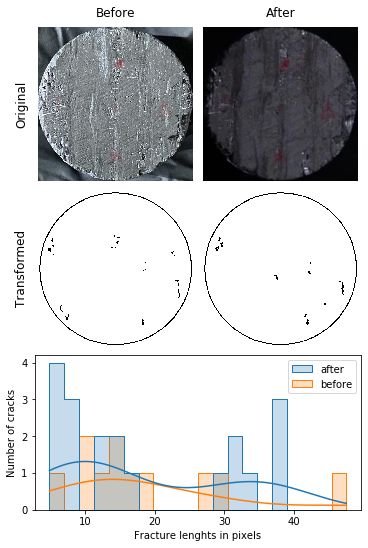

<Figure size 432x288 with 0 Axes>

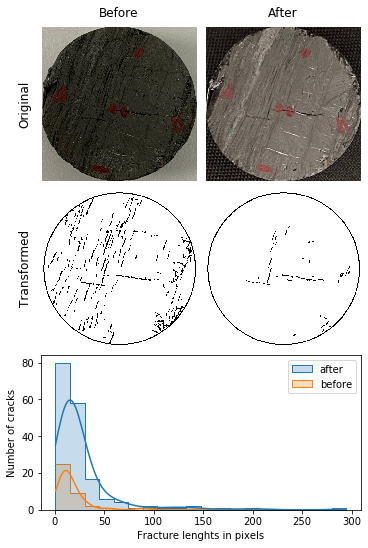

<Figure size 432x288 with 0 Axes>

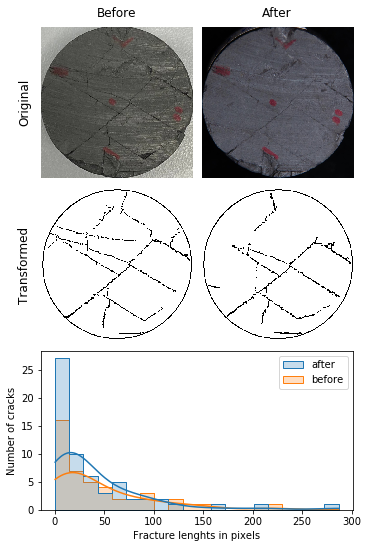

<Figure size 432x288 with 0 Axes>

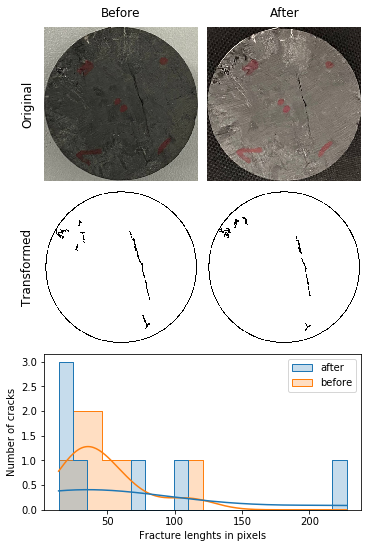

<Figure size 432x288 with 0 Axes>

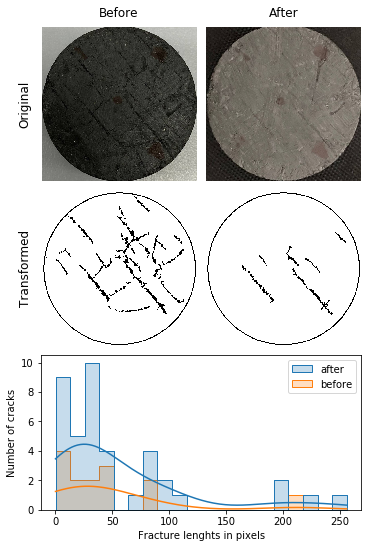

<Figure size 432x288 with 0 Axes>

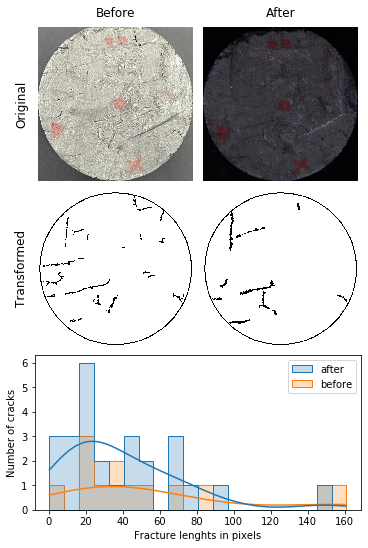

<Figure size 432x288 with 0 Axes>

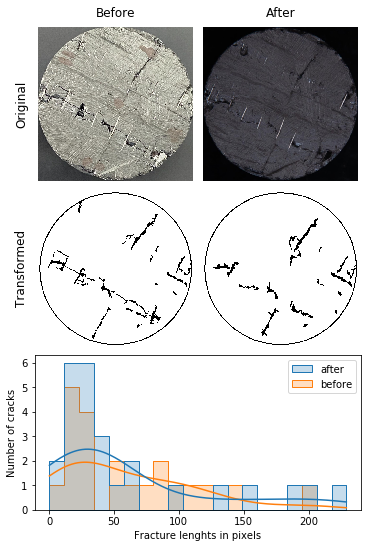

<Figure size 432x288 with 0 Axes>

In [3]:
param_names = [
    "tca",
    "avg_length",
    "25_length",
    "75_length",
    "total_cracks",
    "cd",
]

data = {}

for when in ["after", "before"]:
    data[when] = {"Sample": []}

for filename in range(1, 9):
    lengths_data = {}
    path = f"data/{filename}/"
    fig = plt.figure(
        constrained_layout=True,
        figsize=(5, 7.5),
    )
    gs = fig.add_gridspec(3, 2)

    f_ax1 = fig.add_subplot(gs[0, 0])
    img = imread(path + "after/original.jpg")
    img = cv2.resize(img, (640, 640))
    f_ax1.imshow(img)
    f_ax1.set_title(
        label=f"Before",
        pad=10,
    )
    f_ax1.set_ylabel(
        ylabel="Original",
        fontsize=12,
        labelpad=10,
    )

    f_ax2 = fig.add_subplot(gs[0, 1])
    img = imread(path + "before/original.jpg")
    img = cv2.resize(img, (640, 640))
    f_ax2.imshow(img)
    f_ax2.set_title(
        label=f"After",
        pad=10,
    )

    f_ax3 = fig.add_subplot(gs[1, 0])
    img = imread(path + "after/transformed.bmp")
    img = cv2.circle(img, (240, 240), 235, (0, 0, 0), 2)
    f_ax3.imshow(img, cmap="gray")
    f_ax3.set_ylabel(
        ylabel="Transformed",
        fontsize=12,
        labelpad=10,
    )

    f_ax4 = fig.add_subplot(gs[1, 1])
    img = imread(path + "before/transformed.bmp")
    img = cv2.circle(img, (240, 240), 235, (0, 0, 0), 2)
    f_ax4.imshow(img, cmap="gray")

    for ax in [f_ax1, f_ax2, f_ax3, f_ax4]:
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    
    for when in ["after", "before"]:
        transformed = cv2.imread(path + when + "/transformed.bmp", 1)
        transformed = cv2.cvtColor(transformed, cv2.COLOR_BGR2GRAY)
        params = get_params(transformed)
        for param in param_names:
            if param in data[when]:
                data[when][param].append(params[param])
            else:
                data[when][param] = [params[param]]
        lengths_data[when] = params["lengths"]
        data[when]["Sample"].append(filename)

    f_ax5 = fig.add_subplot(gs[2, :])
    f_ax5.set(
        xlabel="Fracture lenghts in pixels",
        ylabel="Number of cracks"
    )
    sns.histplot(
        data=lengths_data,
        bins=20, kde=True,
        linewidth=1,
        element="step",
        ax=f_ax5,
    )
    plt.savefig(path + "lengths.png", dpi=230)
    plt.show()
    plt.clf()

In [4]:
df_before = pd.DataFrame.from_dict(data["before"]).set_index("Sample")
df_before["when"] = "before"
df_after = pd.DataFrame.from_dict(data["after"]).set_index("Sample")
df_after["when"] = "after"
df_after

,tca,avg_length,25_length,75_length,total_cracks,cd,when
Sample,,,,,,,
1,0.015081,49.703952,17.029386,73.381174,17,1.6,after
2,0.004957,18.893429,8.003905,31.215231,19,0.8,after
3,0.053566,26.886288,10.436362,25.726846,175,9.6,after
4,0.035815,40.141680,7.556373,56.672794,61,3.4,after
5,0.009555,69.370701,19.378860,88.468708,7,1.0,after
6,0.050090,55.485848,14.324458,79.763968,40,4.2,after
7,0.020110,39.842021,17.151010,54.442003,26,2.2,after
8,0.036418,61.727823,21.674990,62.711347,26,3.0,after


In [5]:
df_before

,tca,avg_length,25_length,75_length,total_cracks,cd,when
Sample,,,,,,,
1,0.005139,31.844415,7.344760,31.827294,11,0.4,before
2,0.004487,18.676706,11.638440,23.276880,11,0.6,before
3,0.008389,16.496242,7.536327,18.892435,38,0.8,before
4,0.034124,44.379422,10.119227,62.533660,44,3.0,before
5,0.008483,47.502391,29.275089,54.960421,8,0.6,before
6,0.016247,46.299977,13.173446,49.607118,14,1.4,before
7,0.019596,55.761090,23.917828,68.891522,13,1.2,before
8,0.035274,59.834410,21.260292,91.143658,21,2.0,before


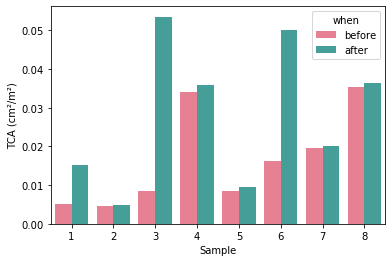

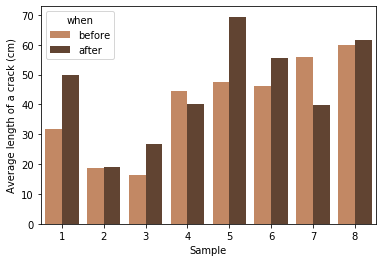

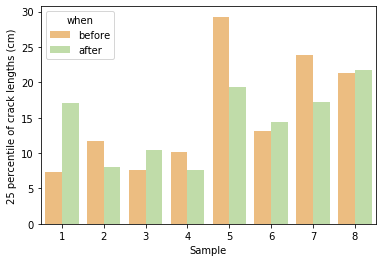

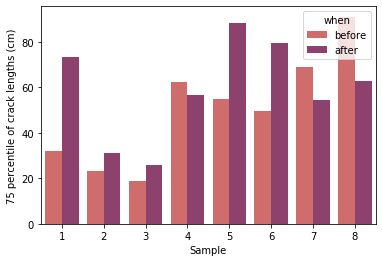

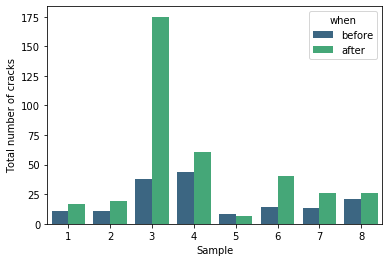

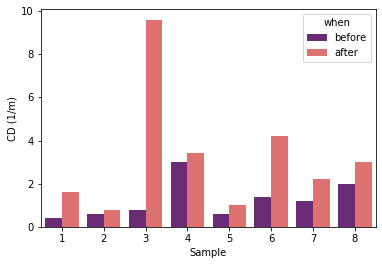

<Figure size 432x288 with 0 Axes>

In [6]:
df = pd.concat([df_before, df_after]).reset_index()

y_label = {
    "tca": "TCA (cm²/m²)",
    "avg_length": "Average length of a crack (cm)",
    "25_length": "25 percentile of crack lengths (cm)",
    "75_length": "75 percentile of crack lengths (cm)",
    "total_cracks": "Total number of cracks",
    "cd": "CD (1/m)",
}

palette = {
    "tca": "husl",
    "avg_length": "copper_r",
    "25_length": "Spectral",
    "75_length": "flare",
    "total_cracks": "viridis",
    "cd": "magma",
}

for param in param_names:
    sns.barplot(
        data=df, x='Sample', 
        y=param, hue='when',
        palette=palette[param], dodge=True
    )
    plt.ylabel(y_label[param])
    plt.savefig(f"data/diagrams/{param}.png", dpi=230)
    plt.show()
    plt.clf()